We'll implement a Real NVP on Iris.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.stats
import scipy.io
import seaborn as sns
import os
import scipy.sparse
from scipy.io import loadmat
import pandas as pd
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tf.keras.layers
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/LukasRinder/normalizing-flows.git

Cloning into 'normalizing-flows'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 148 (delta 13), reused 135 (delta 8), pack-reused 0
Receiving objects: 100% (148/148), 6.31 MiB | 19.08 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [ ]:
%cd normalizing-flows/

/content/normalizing-flows


In [ ]:
import normalizingflows

In [ ]:
from normalizingflows.flow_catalog import RealNVP

tensorflow:  2.4.0
tensorflow-probability:  0.12.1


In [ ]:
from sklearn.datasets import load_iris
data = load_iris(True)[0]

x = ((data - np.mean(data,0))/np.std(data,0)).astype(np.float32)
n = x.shape[0] # number of observations
p = x.shape[1] # number of feat*ures

In [ ]:
layers = 4

In [ ]:
permutation = tf.cast(np.concatenate((np.arange(p/2,p),np.arange(0,p/2))), tf.int32)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(p, tf.float32))

bijectors = []

for i in range(layers):
    bijectors.append(tfb.BatchNormalization())
    bijectors.append(RealNVP(input_shape=p, n_hidden=[32,32]))
    bijectors.append(tfp.bijectors.Permute(permutation))

bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_real_nvp')

flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector
)


Let's just sample from points from $p(x)$ to see the initalised model (before training).

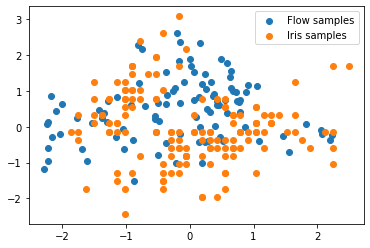

In [ ]:
xgen = flow.sample(100).numpy()

plt.scatter(xgen[:,0],xgen[:,1])
plt.scatter(x[:,0],x[:,1])
plt.legend(['Flow samples', 'Iris samples'])

We can compute $f_\theta$ and $f_\theta^{-1}$ easily:

In [ ]:
bijector(x[:2,:]).numpy() # f_theta(x_1) and f_theta(x_2)

array([[-1.1442871 ,  1.2889416 , -2.5563812 ,  1.4189088 ],
       [-1.2537644 ,  0.02136454, -2.982741  ,  0.547803  ]],
      dtype=float32)

In [ ]:
bijector.inverse(x[:2,:]).numpy() # f_theta^(-1)(x_1) and f_theta^(-1)(x_2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


array([[ 0.99962544,  0.9995227 , -0.99949974,  0.99949986],
       [-0.9996255 , -0.9995227 ,  0.9994998 , -0.9994998 ]],
      dtype=float32)

In [ ]:
params =  flow.trainable_variables

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
@tf.function
def train_step(data):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    loss = -tf.reduce_mean(flow.log_prob(data))  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, params)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params))  # Adam iteration

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(x).shuffle(n).batch(32) # Batches of size 32

In [ ]:
EPOCHS = 20001

for epoch in range(1,EPOCHS+1):
  for data in train_data:
    train_step(data) # Adam iteration
  if (epoch % 1000) == 1:
    ll_train = tf.reduce_mean(flow.log_prob(data))
    print('Epoch  %g' %epoch)
    print('Training log-likelihood %g' %ll_train.numpy())
    print('-----------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Epoch  1
Training log-likelihood -6.2762
-----------
Epoch  1001
Training log-likelihood -2.96461
-----------
Epoch  2001
Training log-likelihood -2.24732
-----------
Epoch  3001
Training log-likelihood -2.2694
-----------
Epoch  4001
Training log-likelihood -2.41465
-----------
Epoch  5001
Training log-likelihood -1.64345
-----------
Epoch  6001
Training log-likelihood -2.07701
-----------
Epoch  7001
Training log-likelihood -2.51249
-----------
Epoch  8001
Training log-likelihood -2.58125
-----------
Epoch  9001
Training log-likelihood -1.72651
-----------
Epoch  10001
Training log-likelihood -1.42071
-----------
Epoch  11001
Training log-likelihood -1.47177
-----------
Epoch  12001
Training log-likelihood -1.69175
-----------
Epoch  13001
Training log-likelihood -2.11553
-----------
Epoch  14001
Training log-likelihood -2.20688
-----------
Epoch  15001
Training log-likelihood -1.653
-----------
Epoch  16001
Training log-likelihood -2.02274
-----------
Epoch  17001
Training log-likel

We can compare again the true distribution and the flow after training

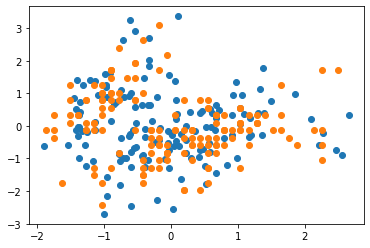

In [ ]:
x_gen = flow.sample(n)

plt.scatter(x_gen[:,0],x_gen[:,1])
plt.scatter(x[:,0],x[:,1])

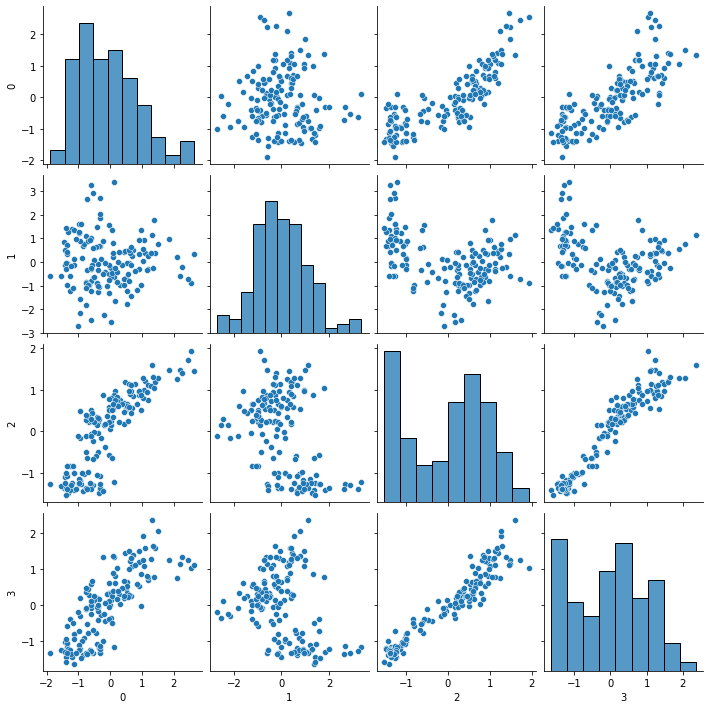

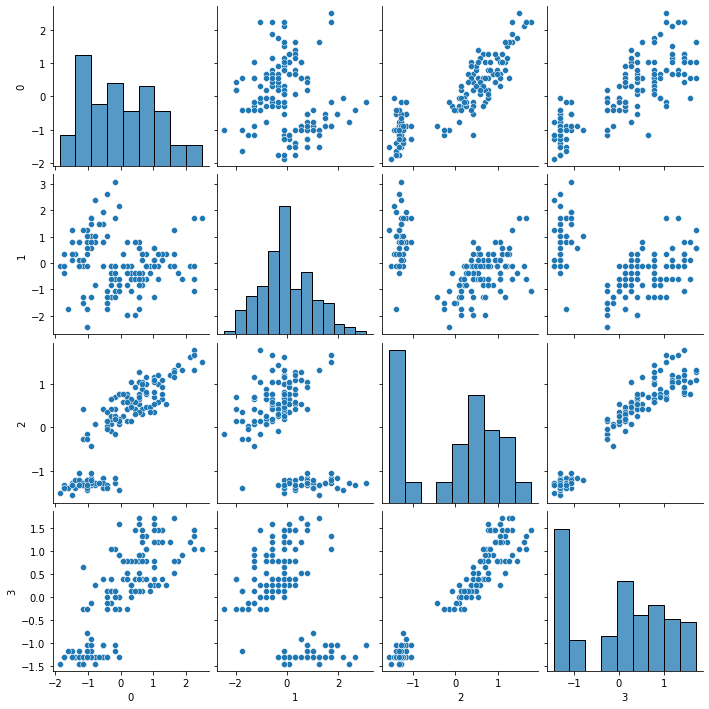

In [ ]:
sns.pairplot(pd.DataFrame(data = x_gen.numpy()))
sns.pairplot(pd.DataFrame(data = x))

The results are okay, but the flow distribution look too smooth compared to the clustered true distribution. On way of having a clustered flow would be to use a mixture of Gaussians as a base distribution, as done below.

In [ ]:
mu1 = tf.Variable(tf.random.normal([p])/3, dtype=tf.float32)
mu2 = tf.Variable(tf.random.normal([p])/3, dtype=tf.float32)


base_mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5,0.5]), # equal proportions
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[mu1,  # component 1
             mu2],  # component 2
        scale_diag = np.ones(p, dtype = np.float32)))

In [ ]:
bijectors_mix = []

for i in range(layers):
    bijectors_mix.append(tfb.BatchNormalization())
    bijectors_mix.append(RealNVP(input_shape=p, n_hidden=[32,32]))
    bijectors_mix.append(tfp.bijectors.Permute(permutation))

bijectors_mix = tfb.Chain(bijectors=list(reversed(bijectors_mix)), name='chain_of_real_nvp_with_mixture_base')

flow_mix = tfd.TransformedDistribution(
    distribution=base_mix,
    bijector=bijectors_mix
)

In [ ]:
params_mix =  list(flow_mix.trainable_variables) + [mu1] + [mu2]

optimizer_mix = tf.keras.optimizers.Adam(learning_rate=0.00001)

In [ ]:
@tf.function
def train_step_mix(data):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    base_mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
        probs=[0.5,0.5]), # equal proportions
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[mu1,  # component 1
             mu2],  # component 2
        scale_diag = np.ones(p, dtype = np.float32)))
    
    flow_mix = tfd.TransformedDistribution(
    distribution=base_mix,
    bijector=bijectors_mix
    )


    loss = -tf.reduce_mean(flow_mix.log_prob(data))  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, params_mix)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, params_mix))  # Adam iteration

In [ ]:
EPOCHS = 20001

for epoch in range(1,EPOCHS+1):
  for data in train_data:
    train_step_mix(data) # Adam iteration
  if (epoch % 1000) == 1:
    ll_train = tf.reduce_mean(flow_mix.log_prob(data))
    print('Epoch  %g' %epoch)
    print('Training log-likelihood %g' %ll_train.numpy())
    print('-----------')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Epoch  1
Training log-likelihood -1.86505
-----------
Epoch  1001
Training log-likelihood -1.13029
-----------
Epoch  2001
Training log-likelihood -2.05083
-----------
Epoch  3001
Training log-likelihood -2.3625
-----------
Epoch  4001
Training log-likelihood -2.21324
-----------
Epoch  5001
Training log-likelihood -1.71011
-----------
Epoch  6001
Training log-likelihood -1.58682
-----------
Epoch  7001
Training log-likelihood -2.05155
-----------
Epoch  8001
Training log-likelihood -1.77534
-----------
Epoch  9001
Training log-likelihood -2.55279
-----------
Epoch  10001
Training log-likelihood -2.69908
-----------
Epoch  11001
Training log-likelihood -1.58958
-----------
Epoch  12001
Training log-likelihood -1.54917
-----------
Epoch  13001
Training log-likelihood -1.69457
-----------
Epoch  14001
Training log-likelihood -1.75182
-----------
Epoch  15001
Training log-likelihood -1.82062
-----------
Epoch  16001
Training log-likelihood -1.94009
-----------
Epoch  17001
Training log-li

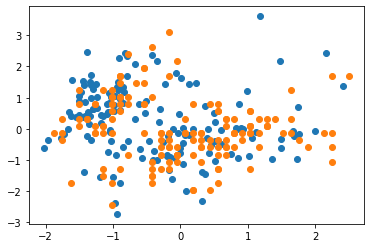

In [ ]:
x_gen = flow_mix.sample(n)

plt.scatter(x_gen[:,0],x_gen[:,1])
plt.scatter(x[:,0],x[:,1])

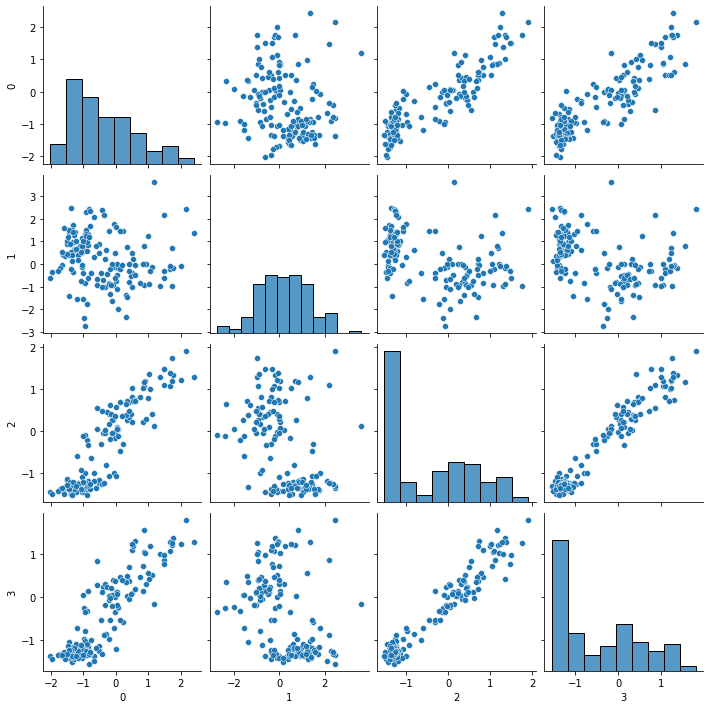

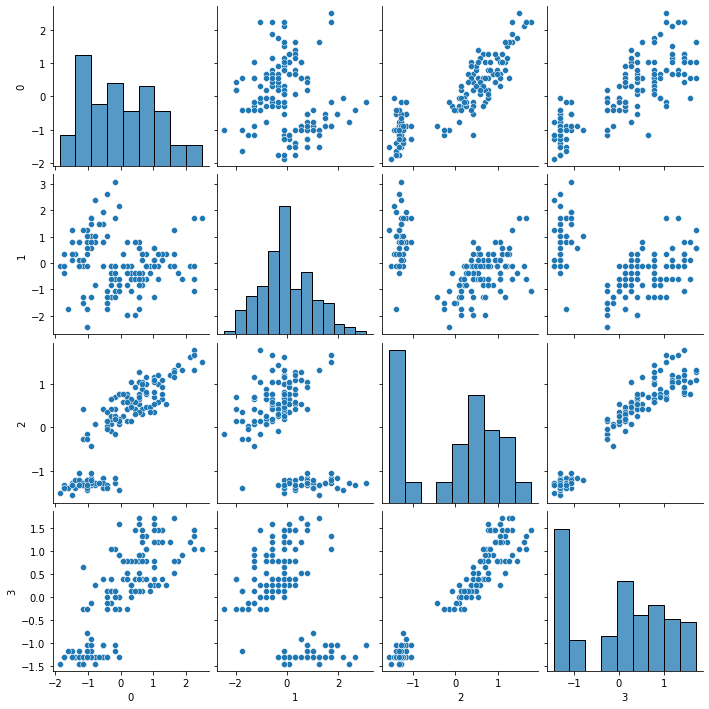

In [ ]:
sns.pairplot(pd.DataFrame(data = x_gen.numpy()))
sns.pairplot(pd.DataFrame(data = x))